# Accuracy/F1 of Our Models on Our Survey Answers

### Choose Models to Test

Possible arguments for the Model:
- trait_name
    - 'language'
    - 'age'
    - 'gender'
    - 'political'
    - 'mbti'
- head_type
    - 'Classification'
    - 'Regression'
    - 'MixedCNN'
    - 'CNN' (if you changed architecture make sure it matches the one in custom heads)
- model
    - 'DistilBERT' - default
    - 'MpNet'
    - 'RoBERTa'
    - 'RoBERTaLarge'
    - 'DeBerta'
- train
    - 'Full' - default
    - 'LoRA'
    - 'Baseline'

In [1]:
import os
os.chdir("../..")

In [2]:
from App.ModelWrapper.model_wrapper import Model

models = [
    Model('language', head_type='CNN'),
    Model('language', head_type='MixedCNN', model="RoBERTaLarge"),
    Model('language', head_type='MixedCNN', model="RoBERTa"),
    Model('language', head_type='Classification', model="RoBERTa"),
    Model('language', head_type='TEST')
]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


language (CNN) loading state dict
Initialized model language (CNN)
language (RoBERTaLarge MixedCNN Full) loading state dict
Initialized model language (RoBERTaLarge MixedCNN Full)
language (RoBERTa MixedCNN Full) loading state dict
Initialized model language (RoBERTa MixedCNN Full)
Initialized model language (RoBERTa Classification Full)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


language (TEST) loading state dict
Initialized model language (TEST)


### Testing Accuracy for Each Trait

language (CNN): 100%|██████████| 36/36 [00:01<00:00, 34.91it/s]


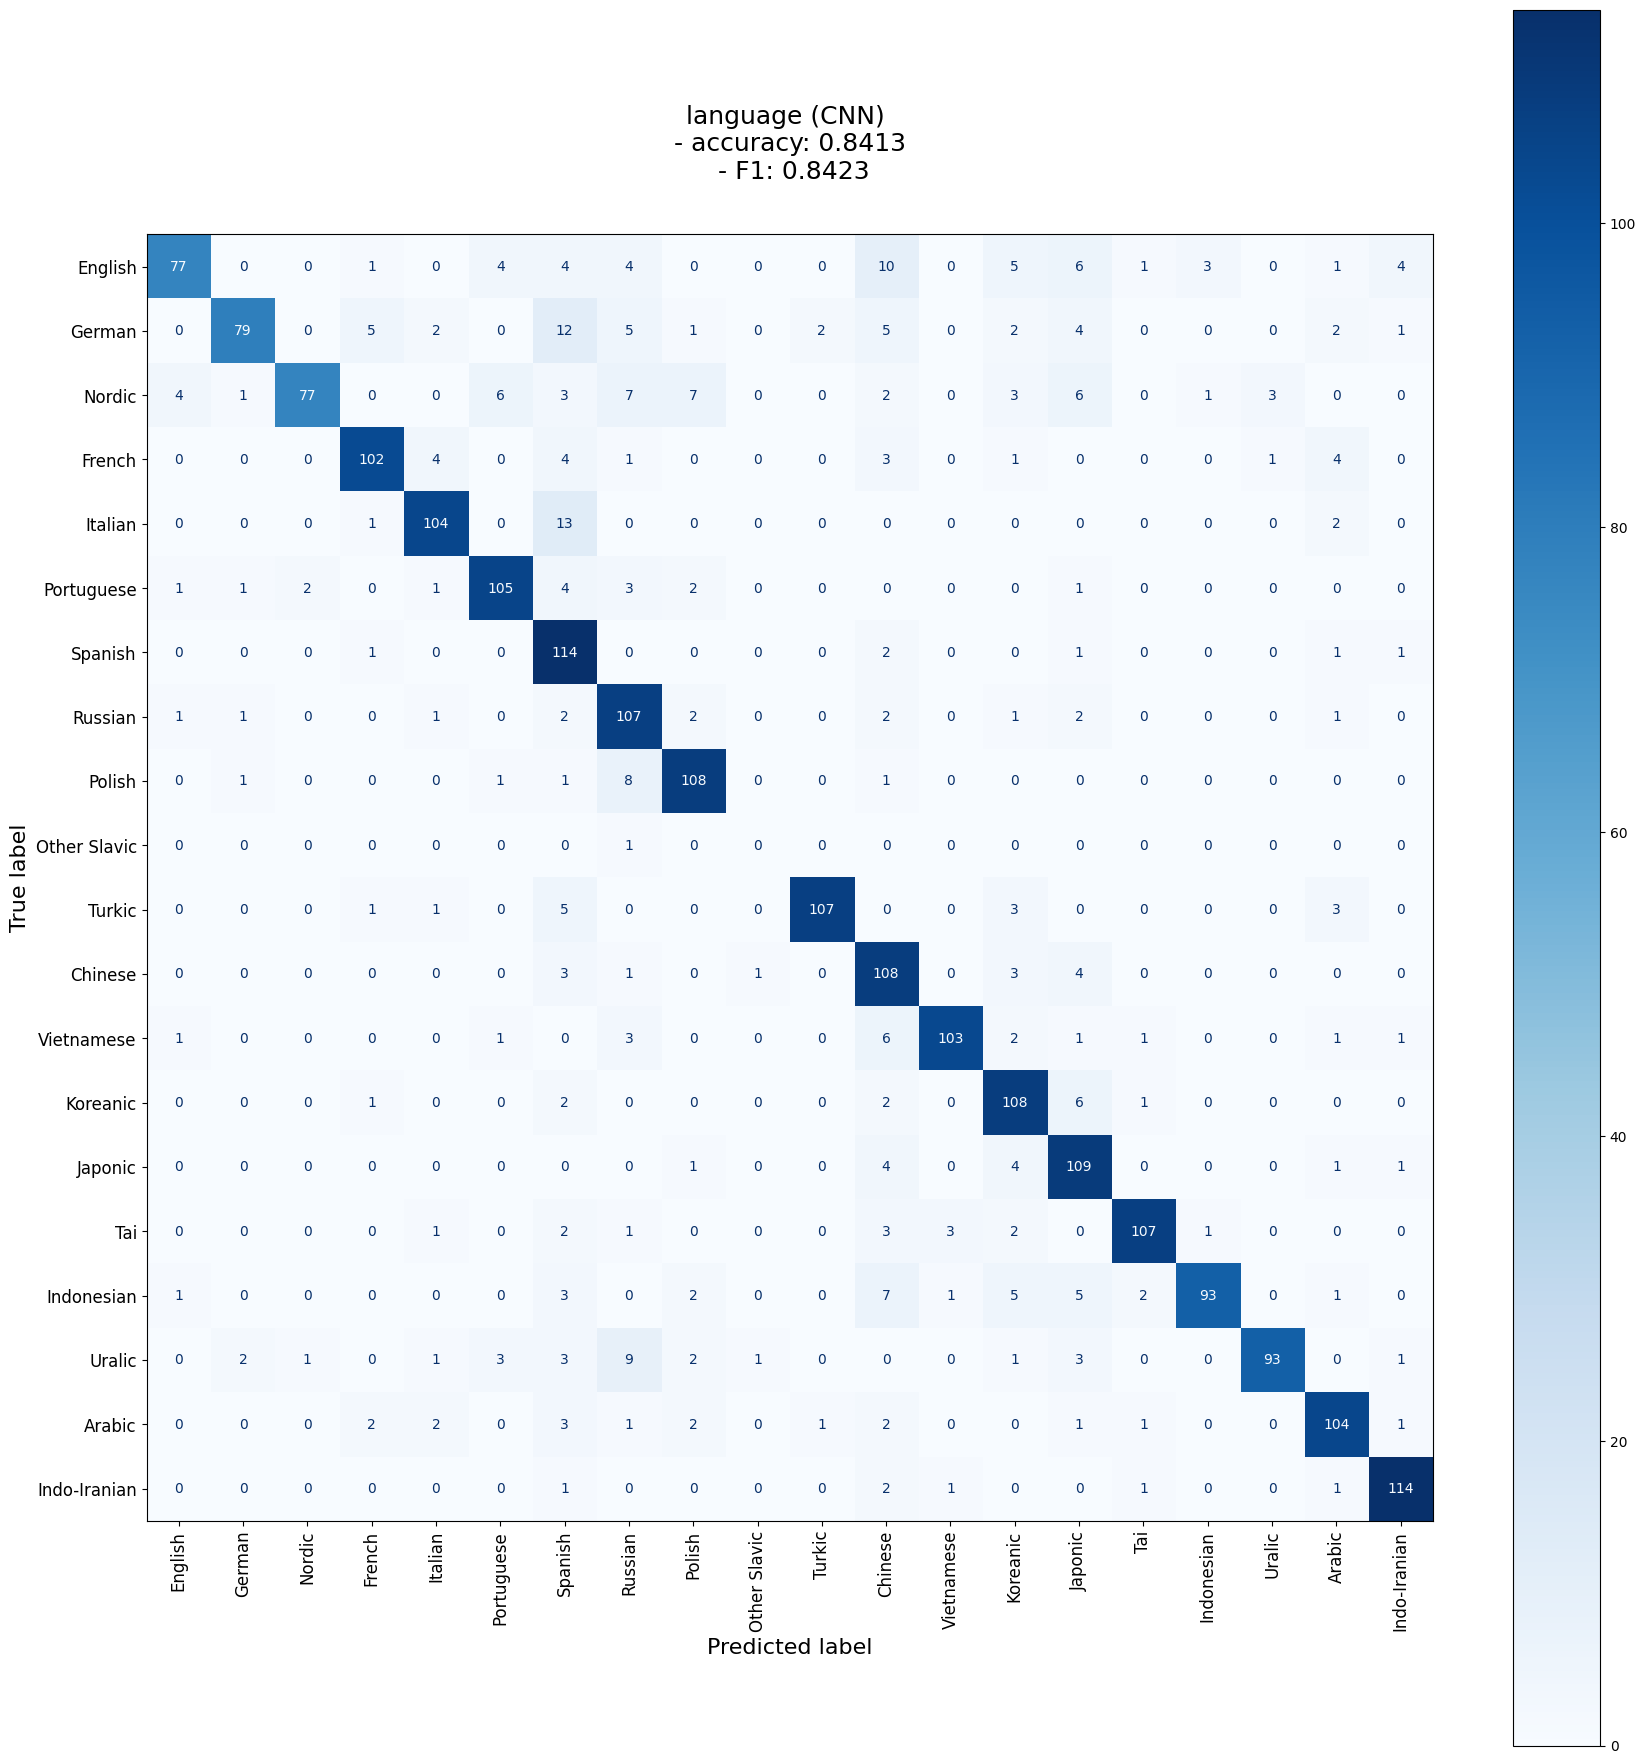


[language (CNN)]: 
 - accuracy: 0.8413 
 - F1: 0.8423



language (RoBERTaLarge MixedCNN Full): 100%|██████████| 36/36 [00:45<00:00,  1.26s/it]


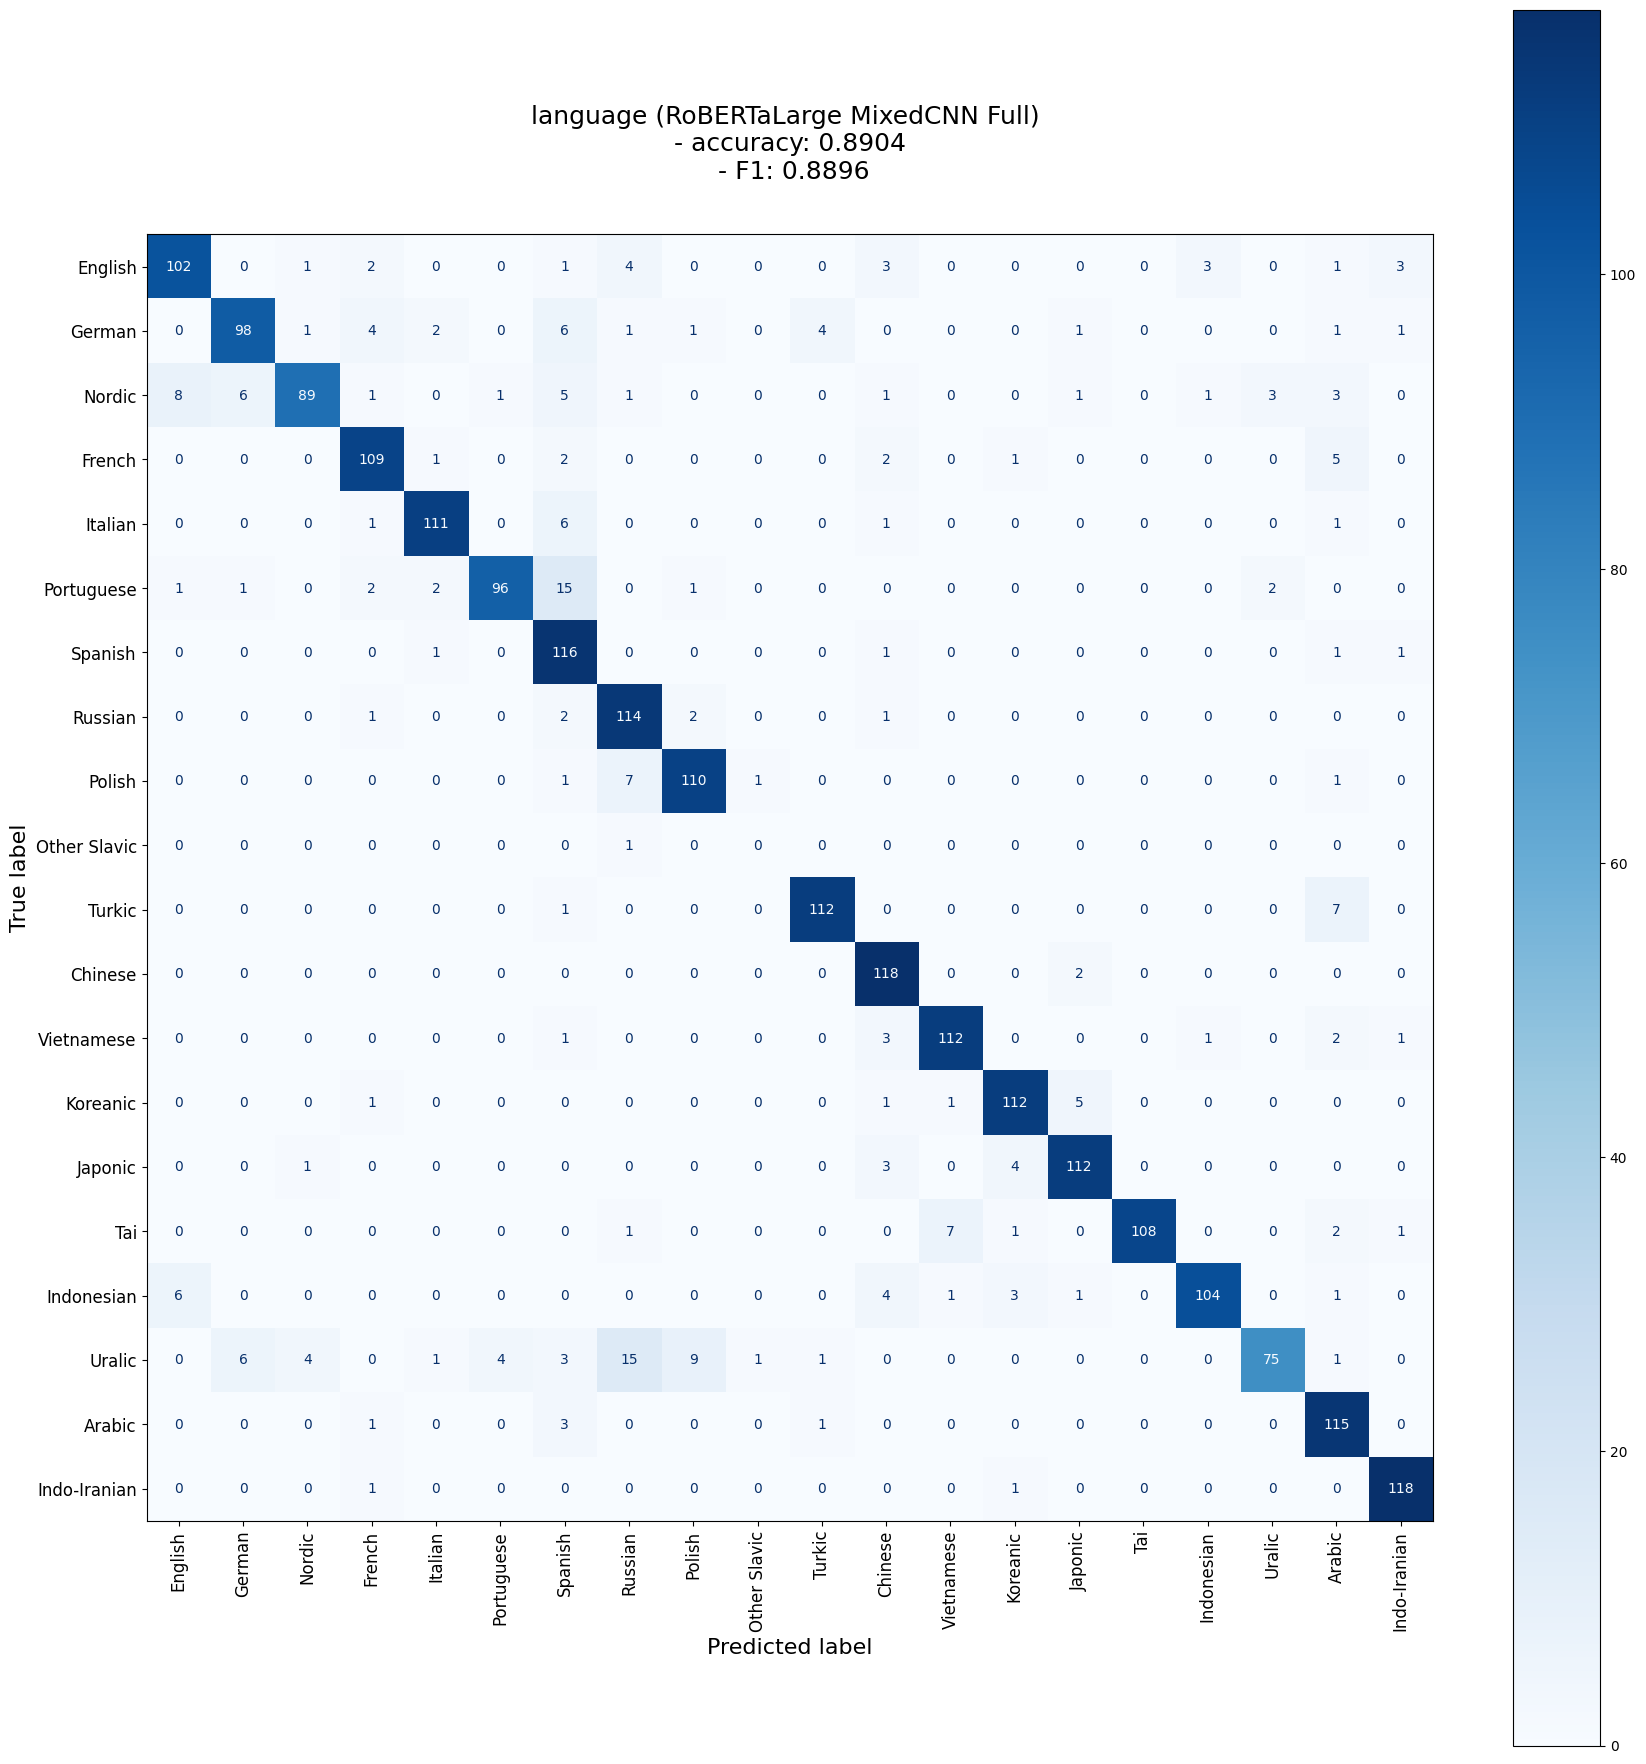


[language (RoBERTaLarge MixedCNN Full)]: 
 - accuracy: 0.8904 
 - F1: 0.8896



language (RoBERTa MixedCNN Full): 100%|██████████| 36/36 [00:12<00:00,  2.90it/s]


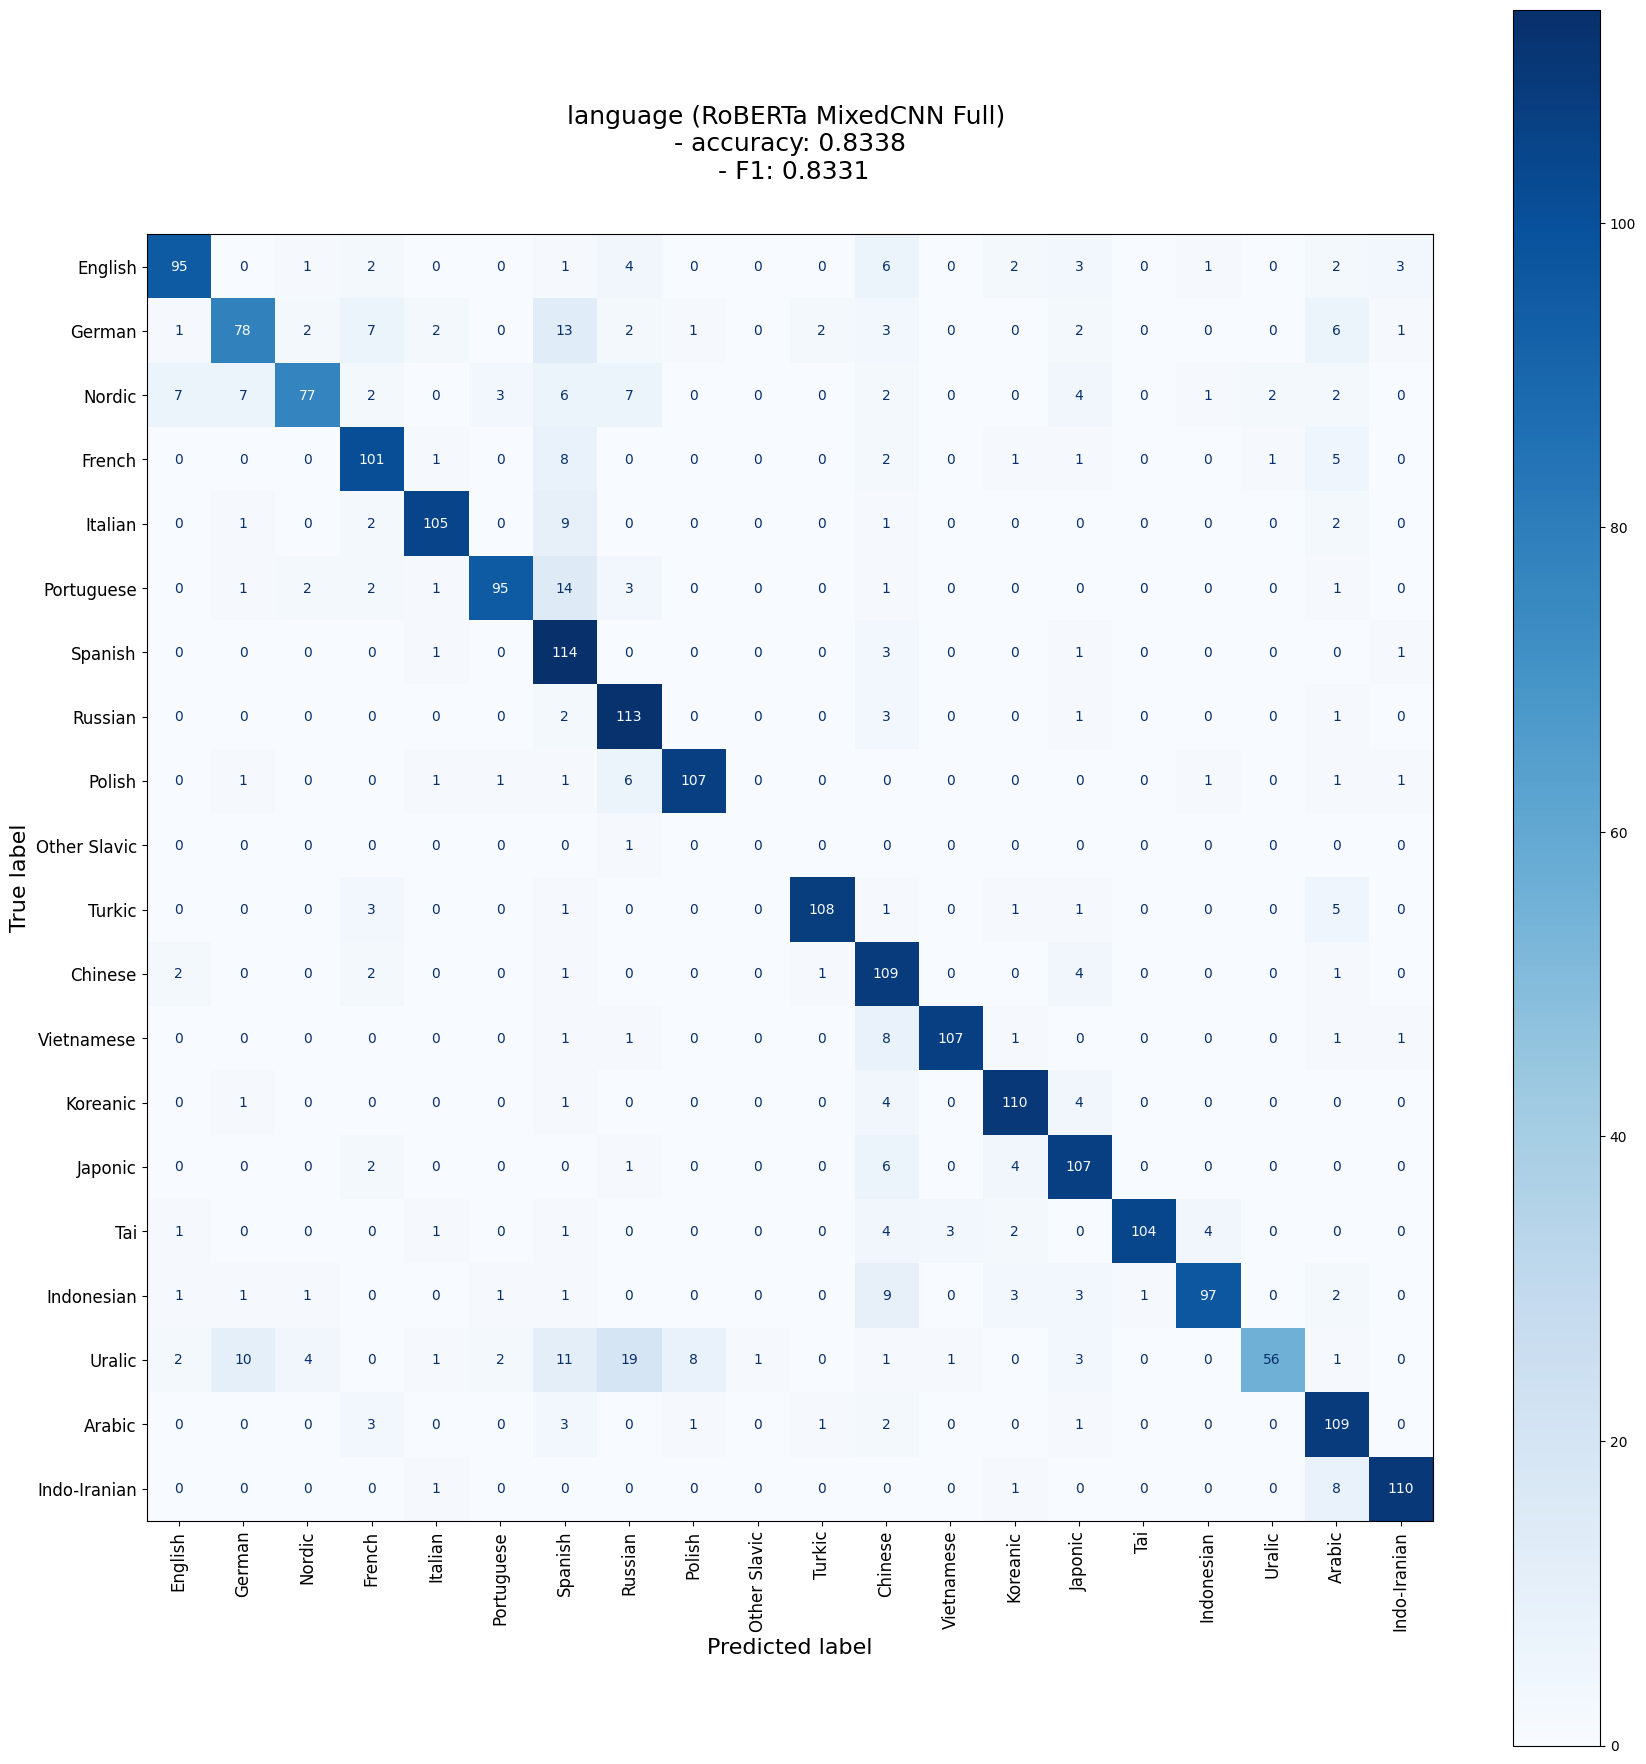


[language (RoBERTa MixedCNN Full)]: 
 - accuracy: 0.8338 
 - F1: 0.8331



language (RoBERTa Classification Full): 100%|██████████| 36/36 [00:11<00:00,  3.03it/s]


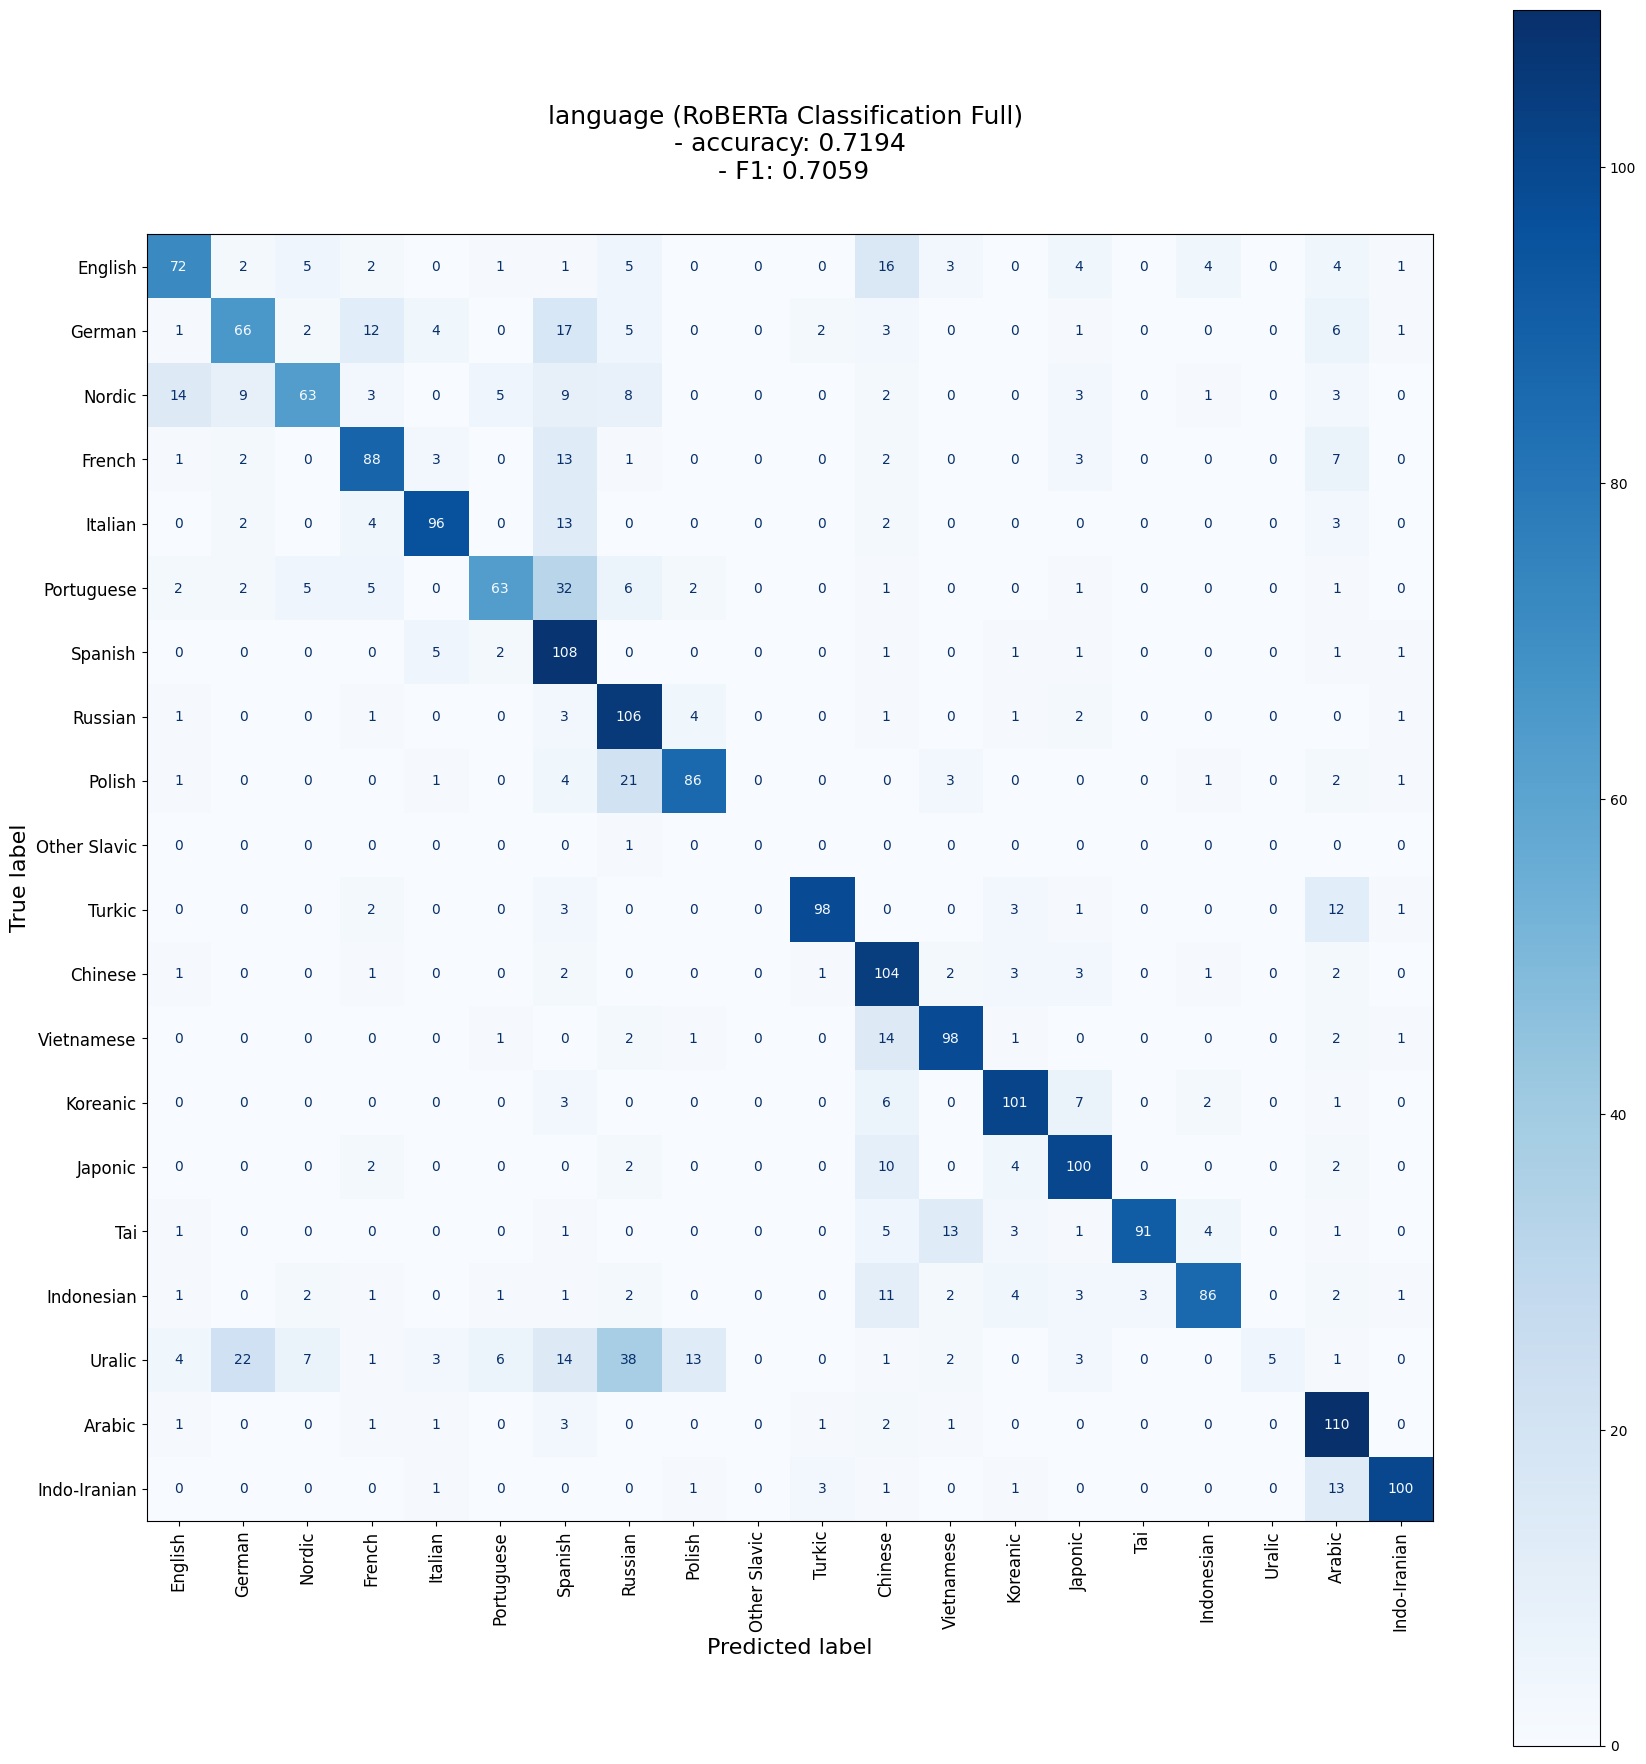


[language (RoBERTa Classification Full)]: 
 - accuracy: 0.7194 
 - F1: 0.7059



language (TEST): 100%|██████████| 36/36 [00:00<00:00, 44.65it/s]


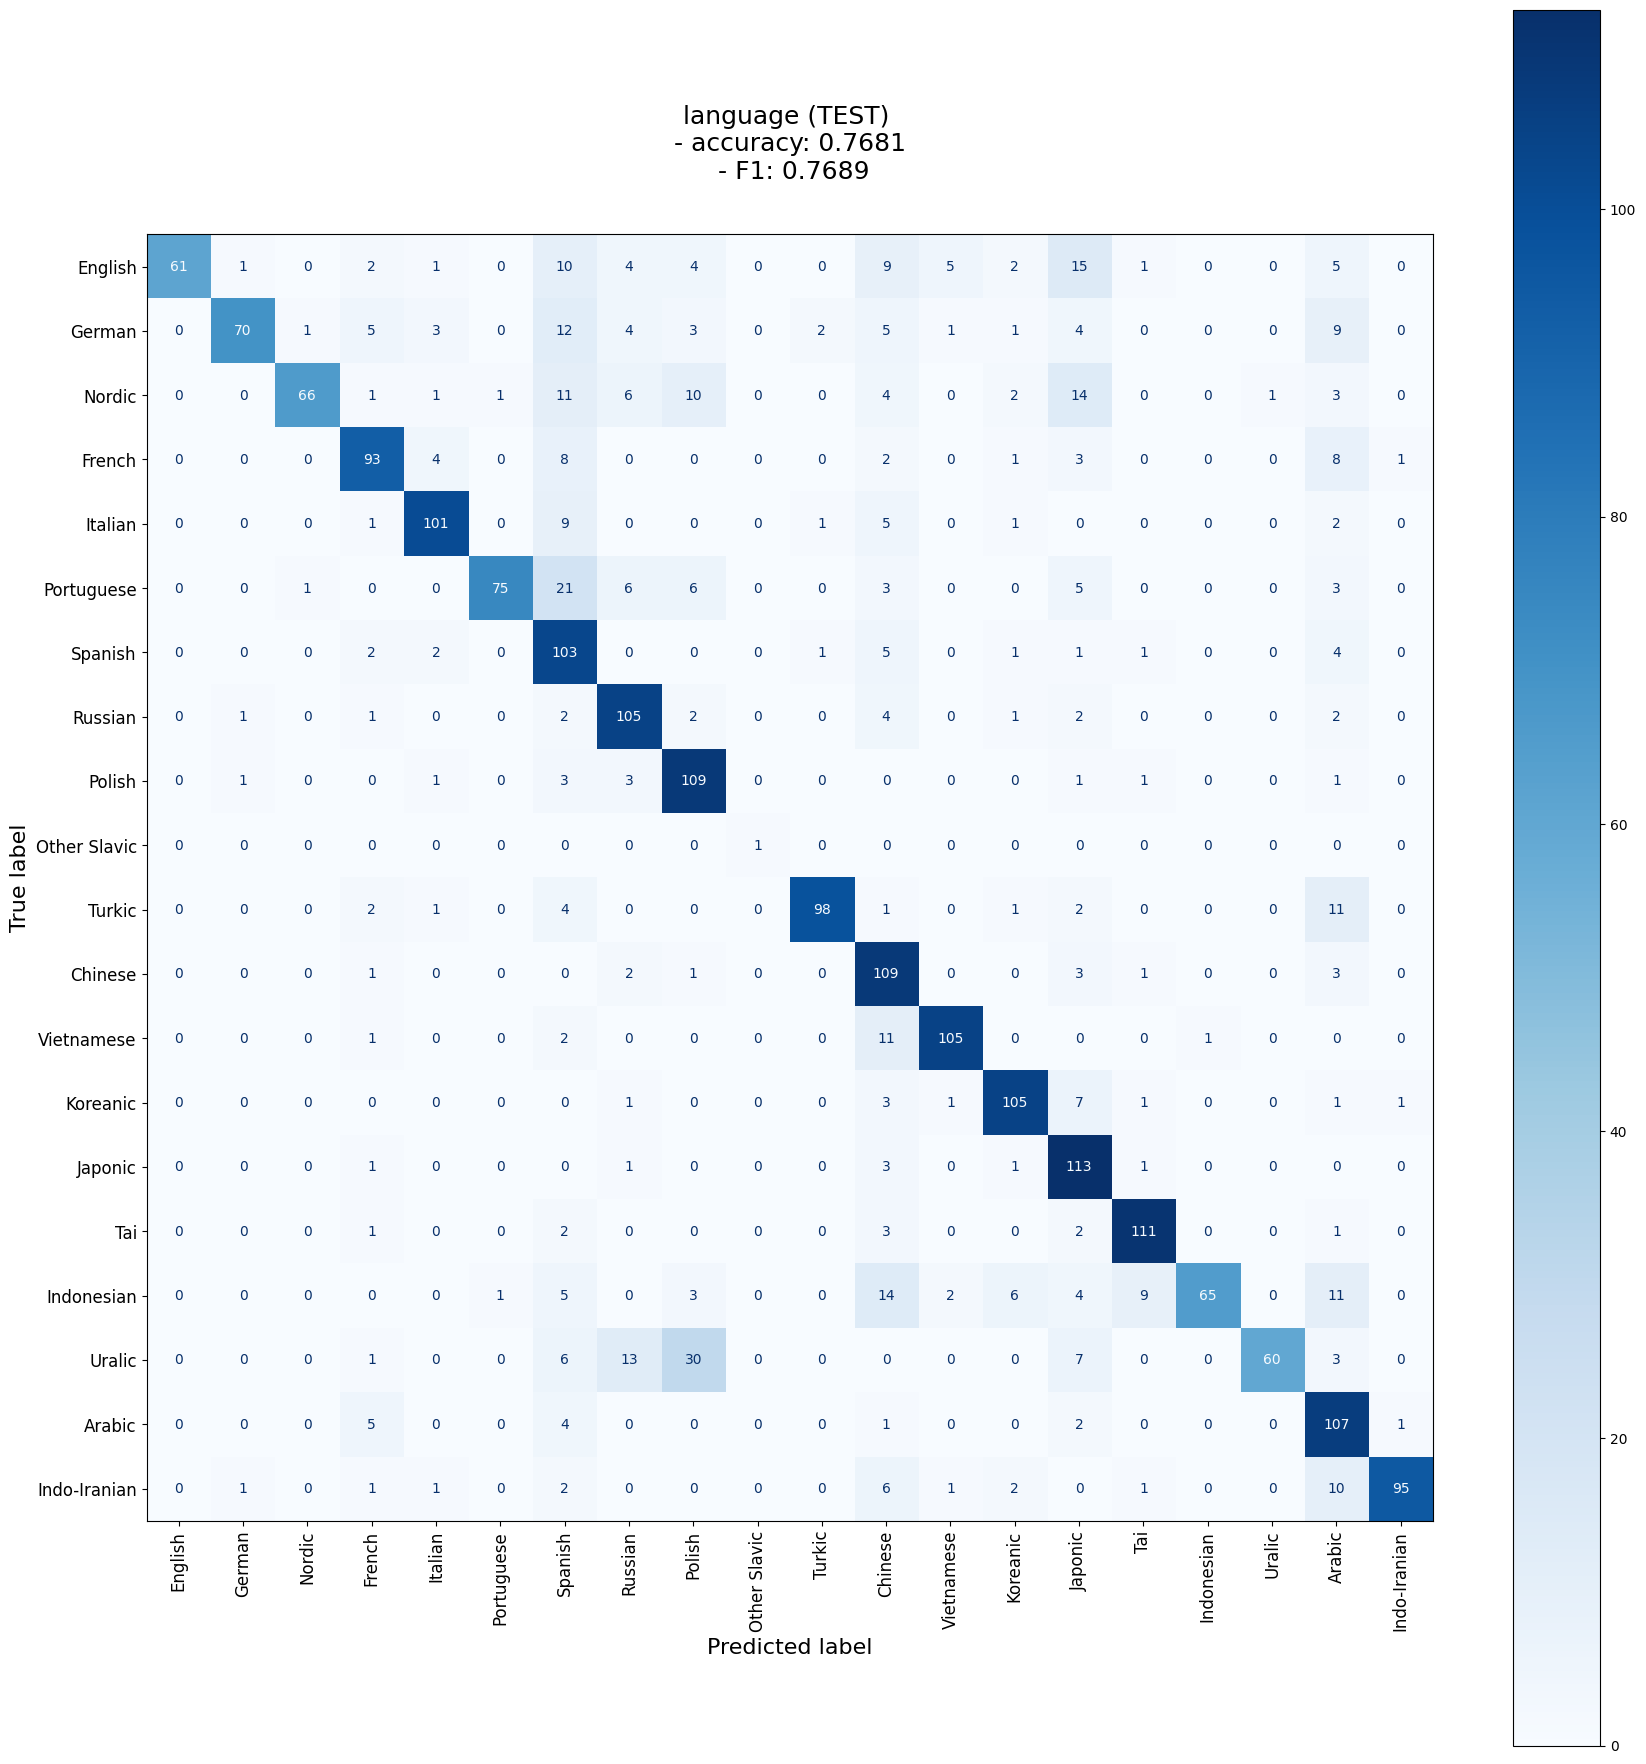


[language (TEST)]: 
 - accuracy: 0.7681 
 - F1: 0.7689



In [3]:
from evaluate import load
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = load("accuracy")
f1_metric = load("f1")

batch_size = 64

for model in models:
    trait = model.name.split(" ")[0]
    # df = pd.read_parquet(f"Training/DATA/{trait}/{'short_' if trait == 'political' else ''}test.parquet")
    # df = pd.read_parquet(f"Training/DATA/{trait}/{'short_' if trait == 'political' else ''}validate.parquet")
    df = pd.read_parquet(f"Training/DATA/{trait}/{'short_' if trait == 'political' else ''}validate_no_other_slavic.parquet")

    if trait == 'political':
        trait = 'political_view'
    if trait == 'mbti':
        trait = 'type'
    invert_labels = {v: k for k, v in model.label_map.items()} if model.label_map != None else lambda x: x

    all_preds = []
    all_refs = df[trait].map(invert_labels).to_numpy()

    for start in tqdm(range(0, len(df), batch_size), desc=model.name):
        batch = df['text'].iloc[start:start + batch_size].tolist()
        outputs = model.predict(batch)

        match model.type:
            case 'Classification' | 'MixedCNN' | 'CNN' | 'TEST':
                outputs = np.argmax(outputs, axis=1)
            case 'Regression':
                outputs = np.round(outputs)

        all_preds.extend(outputs)

    acc = accuracy.compute(predictions=all_preds, references=all_refs)
    f1 = f1_metric.compute(predictions=all_preds, references=all_refs, average="weighted")

    cm = confusion_matrix(all_refs, all_preds)

    fig, ax = plt.subplots(figsize=(18, 18))

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=invert_labels
    )
    disp.plot(
        ax=ax,
        cmap="Blues",
        xticks_rotation=90,
        values_format="d",
        colorbar=True
    )
    ax.set_title(f"{model.name} \n - accuracy: {acc["accuracy"]:.4f} \n - F1: {f1["f1"]:.4f}\n ", fontsize=18, pad=20)
    ax.set_xlabel("Predicted label", fontsize=16)
    ax.set_ylabel("True label", fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=12)

    plt.tight_layout(pad=2.0)
    plt.savefig(f"{model.name}_cm.png")
    plt.show()

    print(f"\n[{model.name}]: \n - accuracy: {acc["accuracy"]:.4f} \n - F1: {f1["f1"]:.4f}\n")
